# Area Calculation

In [2]:
import imutils
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('test1.jpeg', 0)
kernel = np.ones((5,5),np.uint8)
img = cv2.erode(img,kernel,iterations = 1)
ret, thresh = cv2.threshold(img, 127, 255, 0)
color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img = cv2.drawContours(color, contours, -1, (0,255,0), 2)


In [3]:
cnt = contours[2]
M = cv2.moments(cnt)

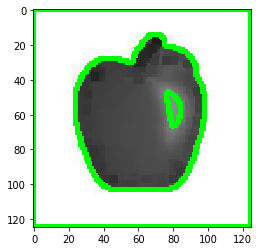

In [4]:
plt.imshow(img)

In [5]:
for val in contours[1:2]:
    print(cv2.contourArea(val))

5112.0


In [6]:
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])


# Center Calculation

In [ ]:
path = 'shapes_and_colors.jpg'

In [ ]:
image = cv2.imread(path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]

In [ ]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

In [ ]:
MIN_THRESH = 0.01

for c in cnts:
    if cv2.contourArea(c) > MIN_THRESH:
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
        cv2.circle(image, (cX, cY), 7, (255, 255, 255), -1)
        cv2.putText(image, "center", (cX - 20, cY - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
        cv2.imshow("Image", image)
        cv2.waitKey(0)

# Shape Detector

In [ ]:
path = 'shapes_and_colors.jpg'

In [ ]:

class ShapeDetector:
    def __init__(self):
        pass
    def detect(self, c):
        shape = "unidentified"
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.04 * peri, True)
        
        if len(approx) == 3:
            shape = "triangle"
        elif len(approx) == 4:
            (x, y, w, h) = cv2.boundingRect(approx)
            ar = w / float(h)
            shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
        elif len(approx) == 5:
            shape = "pentagon"
        else:
            shape = "circle"
        return shape

In [ ]:
image = cv2.imread(path)
resized = imutils.resize(image, width=300)
ratio = image.shape[0] / float(resized.shape[0])
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
sd = ShapeDetector()

In [ ]:
for c in cnts:
    M = cv2.moments(c)
    cX = int((M["m10"] / M["m00"]) * ratio)
    cY = int((M["m01"] / M["m00"]) * ratio)
    shape = sd.detect(c)
    c = c.astype("float")
    c *= ratio
    c = c.astype("int")
    cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
    cv2.putText(image, shape, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX,
        0.5, (255, 255, 255), 2)
    cv2.imshow("Image", image)
    cv2.waitKey(0)

# Labeling Color of Image

In [ ]:
path = 'rgy.jpeg'

In [ ]:
from scipy.spatial import distance as dist
from collections import OrderedDict
import numpy as np
import cv2
class ColorLabeler:
    def __init__(self):
        colors = OrderedDict({ "red": (255, 0, 0), "green": (0, 255, 0),"blue": (0, 0, 255)})
        self.lab = np.zeros((len(colors), 1, 3), dtype="uint8")
        self.colorNames = []
        for (i, (name, rgb)) in enumerate(colors.items()):
            self.lab[i] = rgb
            self.colorNames.append(name)
        self.lab = cv2.cvtColor(self.lab, cv2.COLOR_RGB2LAB)
        
    def label(self, image, c):
        mask = np.zeros(image.shape[:2], dtype="uint8")
        cv2.drawContours(mask, [c], -1, 255, -1)
        mask = cv2.erode(mask, None, iterations=2)
        mean = cv2.mean(image, mask=mask)[:3]
        minDist = (np.inf, None)
        for (i, row) in enumerate(self.lab):
            d = dist.euclidean(row[0], mean)
            if d < minDist[0]:
                minDist = (d, i)
        return self.colorNames[minDist[1]]

In [ ]:
image = cv2.imread(path)
resized = imutils.resize(image, width=300)
ratio = image.shape[0] / float(resized.shape[0])
blurred = cv2.GaussianBlur(resized, (5, 5), 0)
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
lab = cv2.cvtColor(blurred, cv2.COLOR_BGR2LAB)
thresh = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)[1]
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
sd = ShapeDetector()
cl = ColorLabeler()

In [ ]:
for c in cnts:
    M = cv2.moments(c)
    cX = int((M["m10"] / M["m00"]) * ratio)
    cY = int((M["m01"] / M["m00"]) * ratio)
    shape = sd.detect(c)
    color = cl.label(lab, c)
    c = c.astype("float")
    c *= ratio
    c = c.astype("int")
    text = "{} {}".format(color, shape)
    cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
    cv2.putText(image, text, (cX, cY),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    cv2.imshow("Image", image)
    cv2.waitKey(0)